In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tabulate import tabulate
import seaborn as sns
import scikitplot as skplt
from numpy import percentile
import math

#pandas
from pandas.plotting import parallel_coordinates
from datetime import date, datetime

#sklearn
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler

from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, make_scorer
from sklearn.metrics import plot_confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

#scikitplot
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_lift_curve
from scikitplot.metrics import plot_cumulative_gain

#mlxtend
from mlxtend.plotting import plot_decision_regions

#matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import pyplot

#seaborn
import seaborn as sns

#scipy
import scipy.stats as stats
from scipy.stats import shapiro, mannwhitneyu, normaltest, kstest
from scipy.stats import boxcox, yeojohnson

In [2]:
def draw_confusion_matrix(clf, X, y, type_flag):
    
    titles_options = [("Confusion matrix, without normalization on %s" %(type_flag), None),
                  ("Normalized confusion matrix on %s" %(type_flag), 'true')]
    
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(clf, X, y,
                                 cmap='OrRd',
                                 normalize=normalize)
        disp.ax_.set_title(title)
    
    plt.show()

In [3]:
def draw_roc_curve(y_test, y_pred, type_flag):
    
    fig, ax = plt.subplots() #figsize = (13,30)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    roc_auc = roc_auc_score(y_test, y_pred, average=None)
    
    ax.plot(fpr, tpr, color = "#ff7400", label='ROC curve (area = %0.2f)' % (roc_auc))
    ax.plot([0, 1], [0, 1], 'k--', color = '#b42cf0')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate') 
    ax.set_title('Roc curve of the model on %s' %(type_flag))
    ax.tick_params(axis='both')
    ax.legend(loc="lower right", fontsize=14, frameon=False)
    
    fig.tight_layout()
    
    plt.show()

In [4]:
def get_metrics(y_test, y_pred):

    metrics = []
    metrics_names = []

    acc = accuracy_score(y_test, y_pred)
    acc = [float('%.2f' % acc)]
    acc_name = accuracy_score.__name__
    metrics.append(acc)
    metrics_names.append(acc_name)

    f1 = f1_score(y_test, y_pred, labels = [0, 1], average='weighted', zero_division = 1)
    f1 = [float('%.2f' % f1)]
    f1_name = f1_score.__name__
    metrics.append(f1)
    metrics_names.append(f1_name)

    prec = precision_score(y_test, y_pred, labels = [0, 1], average = 'weighted', zero_division= 1)        
    prec = [float('%.2f' % prec)]
    prec_name = precision_score.__name__
    metrics.append(prec)
    metrics_names.append(prec_name)

    rec = recall_score(y_test, y_pred, labels = [0, 1], average = 'weighted', zero_division = 1)
    rec = [float('%.2f' % rec)]
    rec_name = recall_score.__name__
    metrics.append(rec)
    metrics_names.append(rec_name)

    auc_score = roc_auc_score(y_test, y_pred, average = None)
    auc_score = [float('%.2f' % auc_score)]
    auc_name = roc_auc_score.__name__
    metrics.append(auc_score)
    metrics_names.append(auc_name)

    metrics = np.array(metrics)
    
    return metrics, metrics_names

In [5]:
def plot_metrics_table(cm, target_names, type_flag, cmap=plt.cm.Pastel1):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    title = 'Metrics of ' + type_flag
    plt.title(title, fontsize=13)
    tick_marks_x = np.arange(0)
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks_x)
    plt.yticks(tick_marks, target_names, fontsize = 12)
    
    plt.tight_layout()

    width, height = cm.shape
    
    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center', fontsize = 11)
    
    plt.show()

<h1>Divide into features and target</h1>

<h2>Training merged</h2>

In [6]:
X_train_merged = pd.read_csv('X_train_merged.csv', index_col=0)
y_train = pd.read_csv('y_train_merged.csv', index_col=0)

In [7]:
print("Original Training merged:", X_train_merged.shape)

Original Training merged: (92834, 55)


In [8]:
numeric_columns = []  # continous variables
for column_name in X_train_merged.columns:
    if ("track_genre_top" not in column_name) and  \
          ("track_date_created_year" not in column_name) and \
            ("track_date_created_season" not in column_name):
                numeric_columns.append(column_name)
print("numeric_columns", len(numeric_columns))

numeric_columns 37


In [9]:
for column in X_train_merged:
    if column not in numeric_columns:
        X_train_merged = X_train_merged.drop(column, axis = 1)
        
print("New Training merged:", X_train_merged.shape)   

New Training merged: (92834, 37)


**X_train_merged with numeric columns with a normal distribution**

In [10]:
X_train_merged_norm = X_train_merged.apply(lambda x: yeojohnson(x)[0])

In [11]:
print("Training merged norm shape:", X_train_merged_norm.shape)

Training merged norm shape: (92834, 37)


In [352]:
#X_train_merged = X_train_merged.values

In [335]:
#X_train_merged_norm = X_train_merged_norm.values

<h2>Test</h2>

In [12]:
X_test = pd.read_csv('X_test.csv', index_col=0)
y_test = pd.read_csv('y_test.csv', index_col=0)

In [13]:
print("Original Test:", X_test.shape)

Original Test: (10874, 55)


In [14]:
numeric_columns = []  # continous variables
for column_name in X_test.columns:
    if ("track_genre_top" not in column_name) and  \
          ("track_date_created_year" not in column_name) and \
            ("track_date_created_season" not in column_name):
                numeric_columns.append(column_name)
print("numeric_columns", len(numeric_columns))

numeric_columns 37


In [15]:
for column in X_test:
    if column not in numeric_columns:
        X_test = X_test.drop(column, axis = 1)
        
print("New Test:", X_test.shape)    

New Test: (10874, 37)


In [16]:
X_test = X_test.values

In [17]:
def plot_decision_boundary(X_tr, y_tr, model, type_flag):
    
    pca = PCA(n_components=2)
    best_visualization_scaler = StandardScaler()
    
    scaled_X_tr = best_visualization_scaler.fit_transform(X_tr)
    X = pca.fit_transform(scaled_X_tr)
    y = y_tr.values.ravel()

    model.fit(X, y)
    
    fig = plot_decision_regions(X=X, y=y, clf=model, legend=2)
    plt.xlabel("PCA component 1")
    plt.ylabel("PCA component 2")
    plt.title("Model's %s decision boundary" % (type_flag))
    plt.legend(loc='best')
    plt.show()

In [18]:
def plot_selected_features_anova(X_tr, clf, best_params, type_flag):
    
    dfscores = pd.DataFrame(clf['reduce_dim'].scores_)
    dfcolumns = pd.DataFrame(X_tr.columns)

    featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
    featureScores.columns = ['Feature', 'Score']
    featureScores = featureScores[featureScores['Score'] != 0]

    best_k = best_params['reduce_dim__k']
    
    # plot feature importance
    fig = plt.figure(figsize=(8, 10))
    
    # keeping ongly best_k features, ordered in descending score
    ordered_k_feature_scores = featureScores.sort_values('Score', ascending=False).iloc[:best_k]
    
    sns.barplot(y='Feature', x='Score', data=featureScores, color= "#ff7400",
                                                            order=ordered_k_feature_scores.Feature)
    
    plt.title("%s feature importance using %s" % (type_flag, 'ANOVA'))
    plt.show()

In [19]:
def plot_classification_report(y_test, y_pred, type_flag):
    
    model_report = classification_report(y_test, y_pred, output_dict=True)
    
    model_r = pd.DataFrame(model_report).iloc[:-1, :].T
    
    sns.heatmap(model_r, annot=True, cmap='OrRd', cbar=False)
    
    plt.title("%s classification report" % (type_flag))
    
    plt.show()

<h2>Analysis</h2>

**Scalers to test**

In [20]:
scalers_to_test = [MinMaxScaler(), MaxAbsScaler(), RobustScaler(), StandardScaler()]

**Define pipelines**

In [21]:
def get_pipelines(model):
    pipelines = []
    
    p = Pipeline([('scaler', 'passthrough'),
                  ('knn', model)])
    pipelines.append(('NO_feature_selection', p))
    
    p = Pipeline([('scaler', 'passthrough'),
              ('reduce_dim', 'passthrough'),
              ('knn', model)])
    pipelines.append(('Feature_selection', p))
    
    return pipelines

**Define the hyperparameters to tune**

In [22]:
sqrt_records = round(math.sqrt(X_train_merged.shape[0]))
k_range = list(range(3, sqrt_records*2, 2))

params1 = {'scaler': scalers_to_test,
          'knn__n_neighbors': k_range,
          'knn__weights': ['uniform', 'distance'],
          'knn__p': [1, 2]}

params2 = [
          {'scaler': scalers_to_test,
          'reduce_dim': [SelectKBest(f_classif)],
          'reduce_dim__k': [i+1 for i in range(X_train_merged.shape[1])],
          'knn__n_neighbors': k_range,
          'knn__weights': ['uniform', 'distance'],
          'knn__p': [1, 2]},

          {'scaler': scalers_to_test,
          'reduce_dim': [PCA()],
          'reduce_dim__n_components': [i+1 for i in range(X_train_merged.shape[1])],
          'knn__n_neighbors': k_range,
          'knn__weights': ['uniform', 'distance'],
          'knn__p': [1, 2]},
    
          {'scaler': scalers_to_test,
           'reduce_dim': [SequentialFeatureSelector(KNeighborsClassifier())],
           'reduce_dim__n_features_to_select': [i+1 for i in range(X_train_merged.shape[1])],
           'reduce_dim__scoring': 'f1_weighted',
           'knn__n_neighbors': k_range,
           'knn__weights': ['uniform', 'distance'],
           'knn__p': [1, 2]}
          ]

**Randomized Grid Search CV (Validation)**

Fitting 3 folds for each of 10 candidates, totalling 30 fits
NO_feature_selection

{'scaler': MinMaxScaler(), 'knn__weights': 'uniform', 'knn__p': 2, 'knn__n_neighbors': 159}
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=159))])
Confusion matrix


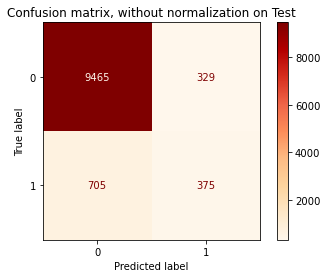

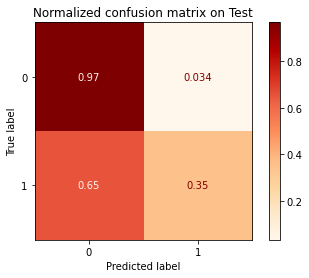

Classification report
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      9794
           1       0.53      0.35      0.42      1080

    accuracy                           0.90     10874
   macro avg       0.73      0.66      0.68     10874
weighted avg       0.89      0.90      0.90     10874




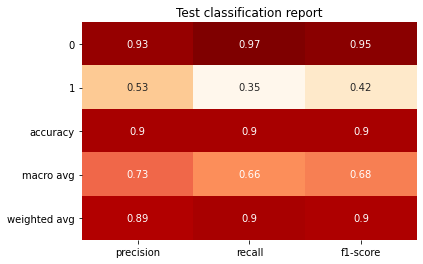

Metrics


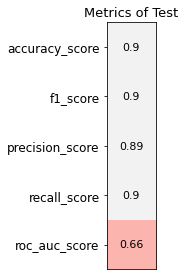



Roc curve



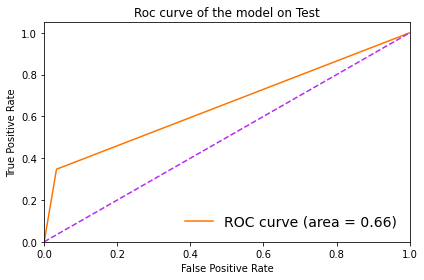


Lift Curve


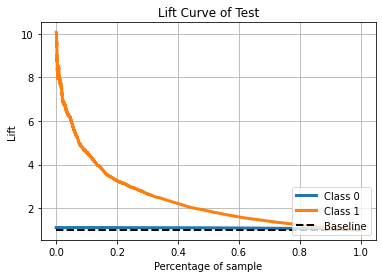

Roc Curves


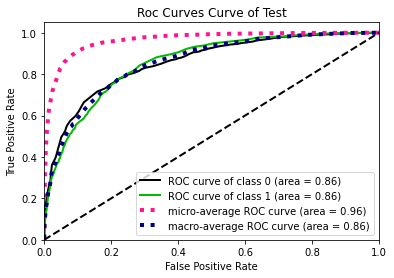

Precision Recall Curve


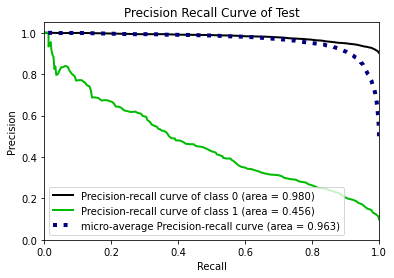

Cumulative Gains Curve


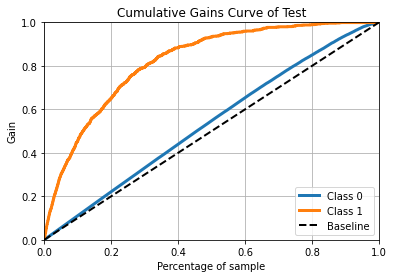

Decision boundary


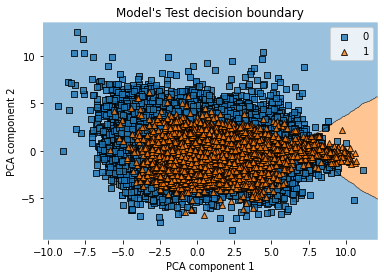

------------------------------------------------------------------------------------------------------

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.88942738 0.88706293        nan        nan        nan
        nan        nan        nan        nan]
  warnings.warn(


Feature_selection

{'scaler': MinMaxScaler(), 'reduce_dim__k': 36, 'reduce_dim': SelectKBest(k=36), 'knn__weights': 'uniform', 'knn__p': 1, 'knn__n_neighbors': 131}
Pipeline(steps=[('scaler', MinMaxScaler()), ('reduce_dim', SelectKBest(k=36)),
                ('knn', KNeighborsClassifier(n_neighbors=131, p=1))])
Selected features


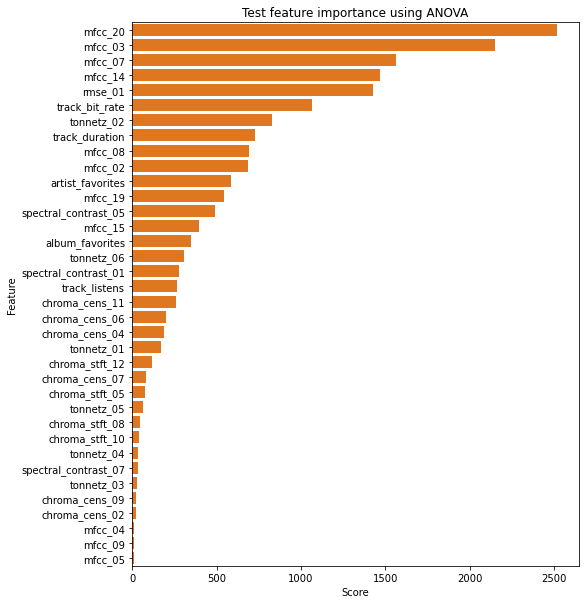


Confusion matrix


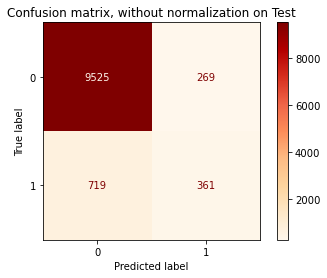

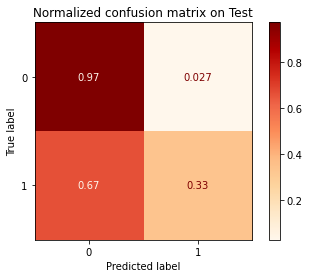

Classification report
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      9794
           1       0.57      0.33      0.42      1080

    accuracy                           0.91     10874
   macro avg       0.75      0.65      0.69     10874
weighted avg       0.89      0.91      0.90     10874




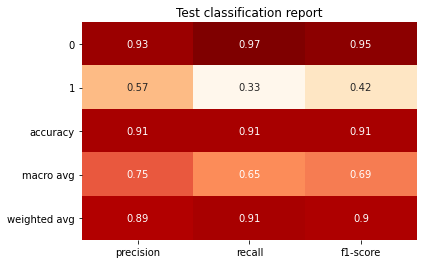

Metrics


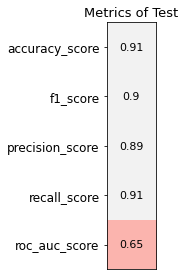



Roc curve



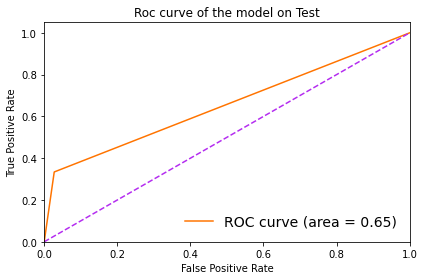


Lift Curve


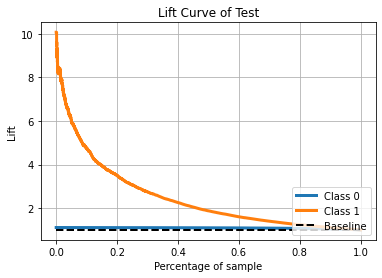

Roc Curves


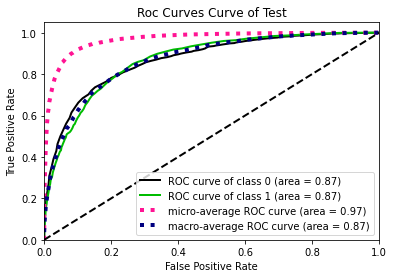

Precision Recall Curve


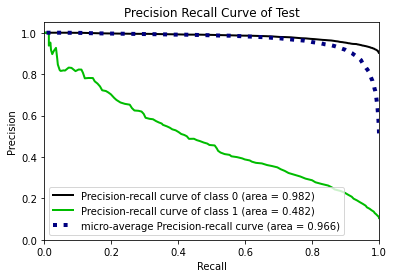

Cumulative Gains Curve


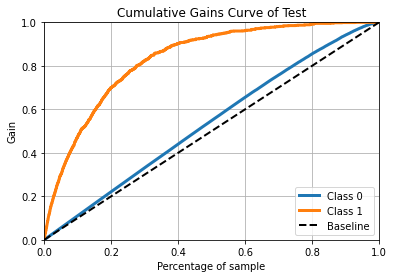

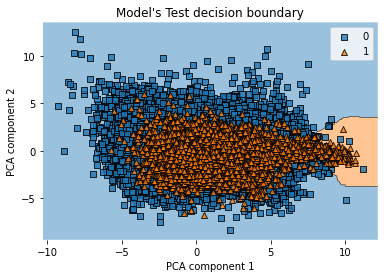

------------------------------------------------------------------------------------------------------



In [23]:
dict_pipelines= {}

model = KNeighborsClassifier()
pipelines = get_pipelines(model)
type_flag = "Test"

for name, pipeline in pipelines:
    
    if name == 'NO_feature_selection':
        params = params1
    else:
        params = params2

    k_fold = StratifiedKFold(n_splits=3) 
    
    randomized_search = RandomizedSearchCV(pipeline, param_distributions = params, scoring = 'f1_weighted', cv = k_fold, refit = 'f1_weighted', verbose = True, n_jobs = -1, n_iter = 10)
    
    if name == 'Feature_selection':
        if isinstance(pipeline.steps[1][1], SelectKBest):
            X_train = X_train_merged_norm.values
        else:
            X_train = X_train_merged.values
    else:
        X_train = X_train_merged.values
    
    randomized_search.fit(X_train, y_train.values.ravel())

    print('\033[1m'+name+'\033[0m')
    print()
    
    print(randomized_search.best_params_)
    print(randomized_search.best_estimator_)

    best_params = randomized_search.best_params_
    clf = randomized_search.best_estimator_

    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)

    metrics, metrics_names = get_metrics(y_test, y_pred)
    
    dict_pipelines[name] = {}
    for m, n in zip(metrics, metrics_names):
        dict_pipelines[name][n] = m[0]

    dict_pipelines[name]['model'] = clf
    dict_pipelines[name]['best_params'] = best_params
    
    #plot selected features (only if reduce_dim == SelectKBest)
    if name == 'Feature_selection':
        if isinstance(clf['reduce_dim'], SelectKBest):
            print('\033[1m'"Selected features"'\033[0m')
            plot_selected_features_anova(X_train_merged, clf, best_params, type_flag)
            print()
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    draw_confusion_matrix(clf, X_test, y_test, type_flag)

    #classification report
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
    print()
    plot_classification_report(y_test, y_pred, type_flag)

    #metrics
    print('\033[1m'"Metrics"'\033[0m')
    plot_metrics_table(metrics, metrics_names, type_flag)

    print()
    print()

    #roc curve
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    draw_roc_curve(y_test, y_pred, type_flag)
    
    print()
    
    #lift curve
    print('\033[1m'"Lift Curve"'\033[0m')
    title = "Lift Curve of " + type_flag
    plot_lift_curve(y_test, y_score, title)
    plt.show()
    
    #roc curves
    print('\033[1m'"Roc Curves"'\033[0m')
    title = "Roc Curves Curve of " + type_flag
    plot_roc(y_test, y_score, title)
    plt.show()
    
    #precision-recall curve
    print('\033[1m'"Precision Recall Curve"'\033[0m')
    title = "Precision Recall Curve of " + type_flag
    plot_precision_recall(y_test, y_score, title)
    plt.show()
    
    #cumulative gains curve
    print('\033[1m'"Cumulative Gains Curve"'\033[0m')
    title = "Cumulative Gains Curve of " + type_flag
    plot_cumulative_gain(y_test, y_score, title)
    plt.show()
    
    #decision boundary (only if there is no feature selection or if feature selection != PCA)
    if name == 'NO_feature_selection': 
        print('\033[1m'"Decision boundary"'\033[0m')
        plot_decision_boundary(X_train_merged.values, y_train, clf['knn'], type_flag)
    
    if name == 'Feature_selection':
        if not isinstance(clf['reduce_dim'], PCA):
            indexes = list(clf['reduce_dim'].get_support(indices=True))
            plot_decision_boundary(X_train_merged.values[:, indexes], y_train, clf['knn'], type_flag)
    
    print('------------------------------------------------------------------------------------------------------')
    print()